#**NLP Project- News Bias and Clickbait detection**
J031- Sanika Mhadgut    
J046- Gayathri Shrikanth

# News Bias Detector

Importing libraries

In [0]:
!pip uninstall tensorflow;

Uninstalling tensorflow-2.2.0rc2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc2


In [0]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 97kB/s 
     |████████████████████████████████| 491kB 37.0MB/s 
     |████████████████████████████████| 3.2MB 38.3MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0


In [0]:
!pip install contractions
import csv
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize



# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn import model_selection, preprocessing, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition, ensemble
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.svm import SVC
from keras.models import load_model
import pickle
# Sampling
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

import contractions
import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping

#wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt


     |████████████████████████████████| 245kB 30.6MB/s 
     |████████████████████████████████| 317kB 50.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=71b0411100a76f7e34ddbd99fdb04d1504aa0811bd88bde45dcb510e120564c2
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



Preprocessing Functions

In [0]:
def read_bias_data(f1, f2):
  cols=["title", "text", "sen_obj", "source", "bias"]
  df = pd.read_csv(f1, skiprows=1, dtype=str, names=cols)
  tdf = pd.read_csv(f2, skiprows=1, dtype=str, names=cols)
  df=df.drop(["sen_obj"], 1)
  tdf=tdf.drop(["sen_obj"], 1)
  df["all"]=df.source + " " + df.title + " "+ df.text
  tdf["all"]=tdf.source + " " + tdf.title + " "+ tdf.text
  df=df.dropna()
  tdf=tdf.dropna()
  return df, tdf

def label_encode(df, tdf):
  tdf["bias"]= tdf["bias"].replace("lc", 1) 
  tdf["bias"]= tdf["bias"].replace("rc", 2) 
  tdf["bias"]= tdf["bias"].replace("left", 1) 
  tdf["bias"]= tdf["bias"].replace("right", 2) 
  tdf["bias"]= tdf["bias"].replace("least-biased",0) 
  df["bias"]= df["bias"].replace("1", 1) 
  df["bias"]= df["bias"].replace("2", 2) 
  df["bias"]= df["bias"].replace("0", 0) 
  df=df.append(tdf)
  return df, tdf
  

In [0]:
def clean_text(text):
    ## Remove puncuation
    text = text.translate(string.punctuation)
    ## Convert words to lower case and split them
    text = text.lower().split()
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    soup = BeautifulSoup(text, "html.parser")
    ## Clean the text
    text = re.sub('\[[^]]*\]', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^\w\s]', '', text)
    p = inflect.engine()
    if text.isdigit():
            text = p.number_to_words(text)

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()
    lemmatizer = WordNetLemmatizer() 
    lemmed_words = [lemmatizer.lemmatize(word, pos='v') for word in text]
    text = " ".join(lemmed_words)

    return text
    
def tokens(str):
  #token = word_tokenize(str)
  token = ngrams(word_tokenize(str), num)
  return token

In [0]:
df, tdf= read_bias_data("https://www.clips.uantwerpen.be/newsaudit_data/BiasClassifier/data/bias_training.csv", "https://www.clips.uantwerpen.be/newsaudit_data/BiasClassifier/data/bias_testing.csv")
df, tdf =label_encode(df, tdf)

df["all_cleaned"]=df["all"].apply(clean_text)
tdf["all_cleaned"]=tdf["all"].apply(clean_text)


In [0]:
print("Train data Shape", df.shape)
print("Test data Shape", tdf.shape)

Train data Shape (23134, 6)
Test data Shape (9336, 6)


Visualizations

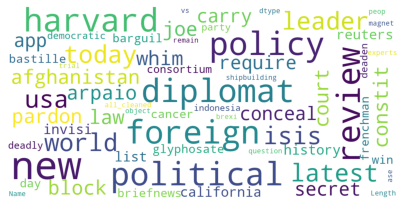

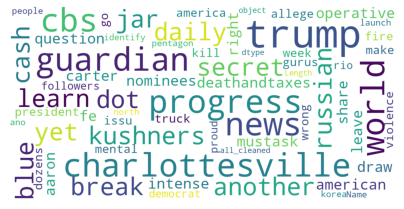

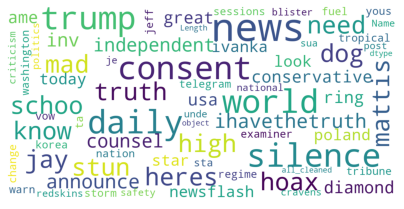

In [0]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
least_bias = df[df['bias']==0]
left = df[df['bias']==1]
right = df[df['bias']==2]
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(7, 7))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(least_bias['all_cleaned'])
show_wordcloud(left['all_cleaned'])
show_wordcloud(right['all_cleaned'])

Word Embedding and LSTM

In [0]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df["all_cleaned"])
sequences = tokenizer.texts_to_sequences(df["all_cleaned"])
data = pad_sequences(sequences, maxlen=350)

In [0]:
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(data, df.bias)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [0]:
unique, counts = np.unique(y_ROS, return_counts=True)
print (np.asarray((unique, counts)))

[[   0    1    2]
 [9672 9672 9672]]
ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
import keras
One_hot_train = keras.utils.to_categorical(y_ROS, num_classes=3)

In [0]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=350))
model_glove.add(Conv1D(64, 5, activation='tanh'))
model_glove.add(Dropout(0.2))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(Dropout(0.2))
model_glove.add(LSTM(100))
model_glove.add(Dense(3, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_glove.fit(X_ROS, One_hot_train, validation_split=0.374, epochs = 3)

Train on 18164 samples, validate on 10852 samples
Epoch 1/3
18164/18164 [==============================] - 122s 7ms/step - loss: 0.5617 - acc: 0.7589 - val_loss: 0.3541 - val_acc: 0.8772
Epoch 2/3
18164/18164 [==============================] - 121s 7ms/step - loss: 0.2416 - acc: 0.9136 - val_loss: 0.2799 - val_acc: 0.9032
Epoch 3/3
18164/18164 [==============================] - 121s 7ms/step - loss: 0.1078 - acc: 0.9624 - val_loss: 0.2076 - val_acc: 0.9359


In [0]:
model_glove.save('/content/drive/My Drive/nlp/model_bias_final2.h5')

In [0]:
model_glove = load_model('/content/drive/My Drive/nlp/model_bias_final2.h5')

Evaluation and Predction

In [0]:
def evaluate_bias_pip(tokenizer, model, tdf):
  tsequences = tokenizer.texts_to_sequences(tdf["all_cleaned"])
  tdata = pad_sequences(tsequences, maxlen=350)
  One_hot_test=keras.utils.to_categorical(tdf["bias"] , num_classes=3)
  print("Evaluate: ", model.evaluate(tdata, One_hot_test))
  y_pred=model.predict(tdata)
  pred=[]
  for i in y_pred:
    pred.append(np.argmax(i))
  print(confusion_matrix(tdf["bias"] , pred))
  print(classification_report(tdf["bias"], pred))



In [0]:
evaluate_bias_pip(tokenizer, model_glove, tdf)

9336/9336 [==============================] - 10s 1ms/step
Evaluate:  [0.21214595775262812, 0.9319837189374465]
[[1296   51   52]
 [ 121 4404  149]
 [ 109  153 3001]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1399
           1       0.96      0.94      0.95      4674
           2       0.94      0.92      0.93      3263

    accuracy                           0.93      9336
   macro avg       0.91      0.93      0.92      9336
weighted avg       0.93      0.93      0.93      9336



In [0]:
def predict_bias(tdf, model):
  out={0:"Least-biased", 1:"Left-biased", 2:"Right biased"}
  tsequences = tokenizer.texts_to_sequences(tdf["text"])
  tdata = pad_sequences(tsequences, maxlen=350)
  y_pred=model.predict(tdata)
  pred=out[np.argmax(y_pred)]
  print("The article is ", pred)

# Click Bait analysis

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_clickbait_data(fi,ft):
  clickbait_data = pd.read_json(open(fi, "r", encoding="utf8"), lines=True)  
  clickbait_data1 = pd.read_json(open(ft, "r", encoding="utf8"), lines=True)
  data = pd.merge(clickbait_data, clickbait_data1, on = 'id')
  labels = data.truthClass.map(lambda x : 1 if x=='clickbait' else 0)
  df = pd.DataFrame({'label':labels, 'text':data.postText})
  df['text'] = df['text'].apply(lambda x: ','.join(map(str, x)))
  return df

In [0]:
df= read_clickbait_data("/content/drive/My Drive/clickbait17-train-170331/instances.jsonl", "/content/drive/My Drive/clickbait17-train-170331/truth.jsonl")

In [0]:
tdf= read_clickbait_data("/content/drive/My Drive/clickbait17-validation-170630/instances.jsonl", "/content/drive/My Drive/clickbait17-validation-170630/truth.jsonl")

In [0]:
tdf.head()

,label,text
0,0,UK’s response to modern slavery leaving victim...
1,1,this is good
2,0,"The ""forgotten"" Trump roast: Relive his brutal..."
3,1,Meet the happiest #dog in the world!
4,0,Tokyo's subway is shut down amid fears over an...


Data preprocessing

In [0]:
df["all_cleaned"]=df["text"].apply(clean_text)
tdf["all_cleaned"]=tdf["text"].apply(clean_text)


Finding Best Model hyperparameters through GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10]
tfidf_vect = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
X=tfidf_vect.fit_transform(df.text)
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X, df.label)
grid_search.best_params_


{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

Pipeline

In [0]:
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
#svc = SVC('C'= 1, 'gamma'= 0.001, 'kernel'= 'linear')
svc= SVC()

In [0]:
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777), svc)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777), svc)

In [0]:
SMOTE_pipeline.fit(df.text, df.label)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=100000, min_df=1,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 tok...
                       out_step='deprecated', random_state=777, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
         

In [0]:
pickle.dump(SMOTE_pipeline, open("/content/drive/My Drive/nlp/model_clickbait_final2.sav", 'wb'))
loaded_model = pickle.load(open("/content/drive/My Drive/nlp/model_clickbait_final2.sav", 'rb'))

Evaluation

In [0]:
def evaluate_clickbait_pip(pipeline, tdf):
  print("Score: ",pipeline.score(tdf.text, tdf.label))
  y_pred=pipeline.predict(tdf.text)
  print(confusion_matrix(tdf.label , y_pred))
  print(classification_report(tdf.label, y_pred))
def predict_clickbait(pipeline, tdf):
  out={0:"Non-Clickbait", 1:"Clickbait"}
  pred=out[pipeline.predict(tdf.text)[0]]
  print("The article is ", pred)


In [0]:
evaluate_clickbait_pip(SMOTE_pipeline, tdf )

Score:  0.7898966117309858
[[14027   750]
 [ 3355  1406]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     14777
           1       0.65      0.30      0.41      4761

    accuracy                           0.79     19538
   macro avg       0.73      0.62      0.64     19538
weighted avg       0.77      0.79      0.76     19538



#Predction on web scraped data

In [0]:
!pip install newspaper3k
import newspaper


     |████████████████████████████████| 215kB 1.4MB/s 
     |████████████████████████████████| 7.4MB 42.9MB/s 
     |████████████████████████████████| 194kB 40.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13539 sha256=5be2bd12acec773e73435a44965af4d1668d9fc2db4b963182c2682c18fc32fc
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3357 sha256=f57eac7efa706e7694f3b54f136128023d6ea720c8b22d32351c784384b8acfe
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=b92f8fd6a12c68cfbfff2c2bd6600e1601bf051871aad1dd6fdc9f29919bac17
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c3

In [0]:
from newspaper import Article
def get_article(url):
  title=[]
  text=[]
  summary=[]
  data= {"title":title, "text":text, "summary":summary}
  article = Article(url, language="en") # en for English 
  article.download() 
  article.parse() 
  article.nlp() 
  print(article.title)
  title.append(article.title) 
  text.append(article.text) 
  summary.append(article.summary) 
  data= {"title":title, "text":text, "summary":summary}
  return pd.DataFrame(data)
  

In [0]:
a=get_article("https://www.bbc.com/news/world-us-canada-52164706")

Michael Atkinson: Trump fires intelligence chief involved in impeachment


In [0]:
predict_clickbait(SMOTE_pipeline,a)

The article is  Non-Clickbait


In [0]:
predict_bias(a, model_glove)

The article is  Left-biased
